In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import h5py
import multigrate

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'

# Load the datasets

In [4]:
scrna = sc.read_h5ad('../data/chen-2019/P0BrainCortex/rna/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 4793 × 4000
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Batch_colors', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/chen-2019/P0BrainCortex/atac/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 4793 × 40623
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'Batch_colors', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [6]:
model = multigrate.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-4,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=30000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=10000,
    validate_every=3000,
    verbose=1
)

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


 |████████████████████| 100.0% iter=30000/30000, time=53.14(s), loss=0.3328, recon=0.3245, kl=47.8923, integ=0.3476, cycle=0.3284, val_loss=0.3366, val_recon=0.3273, val_kl=44.8024, val_integ=0.4837, val_cycle=0.3299

### Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,3000,0.362493,0.333577,48.229518,2.786665,0.337305,0.349657,0.331885,61.334667,1.593257,0.345273
1,6000,0.341146,0.333502,72.452342,0.420195,0.336760,0.337318,0.329014,58.949696,0.476656,0.332422
2,9000,0.335299,0.327899,57.481093,0.294711,0.331986,0.337388,0.328350,48.198074,0.470088,0.332081
3,12000,0.332987,0.324298,49.382867,0.379146,0.328230,0.337779,0.328046,43.250385,0.540859,0.331768
4,15000,0.329918,0.321429,47.805509,0.370852,0.324955,0.337338,0.327601,42.567097,0.548116,0.330590
5,18000,0.342867,0.334314,47.396426,0.381254,0.337657,0.337279,0.327607,42.630814,0.540874,0.330709
6,21000,0.330968,0.322571,46.534352,0.374378,0.325767,0.336982,0.327404,43.065975,0.527195,0.330015
7,24000,0.328670,0.320214,46.688844,0.378710,0.323722,0.336919,0.327362,42.947933,0.526166,0.329982
8,27000,0.336360,0.328088,48.026273,0.346982,0.331454,0.336431,0.327298,43.839535,0.474951,0.330590
9,29999,0.332801,0.324535,47.892268,0.347611,0.328396,0.336642,0.327324,44.802376,0.483722,0.329884


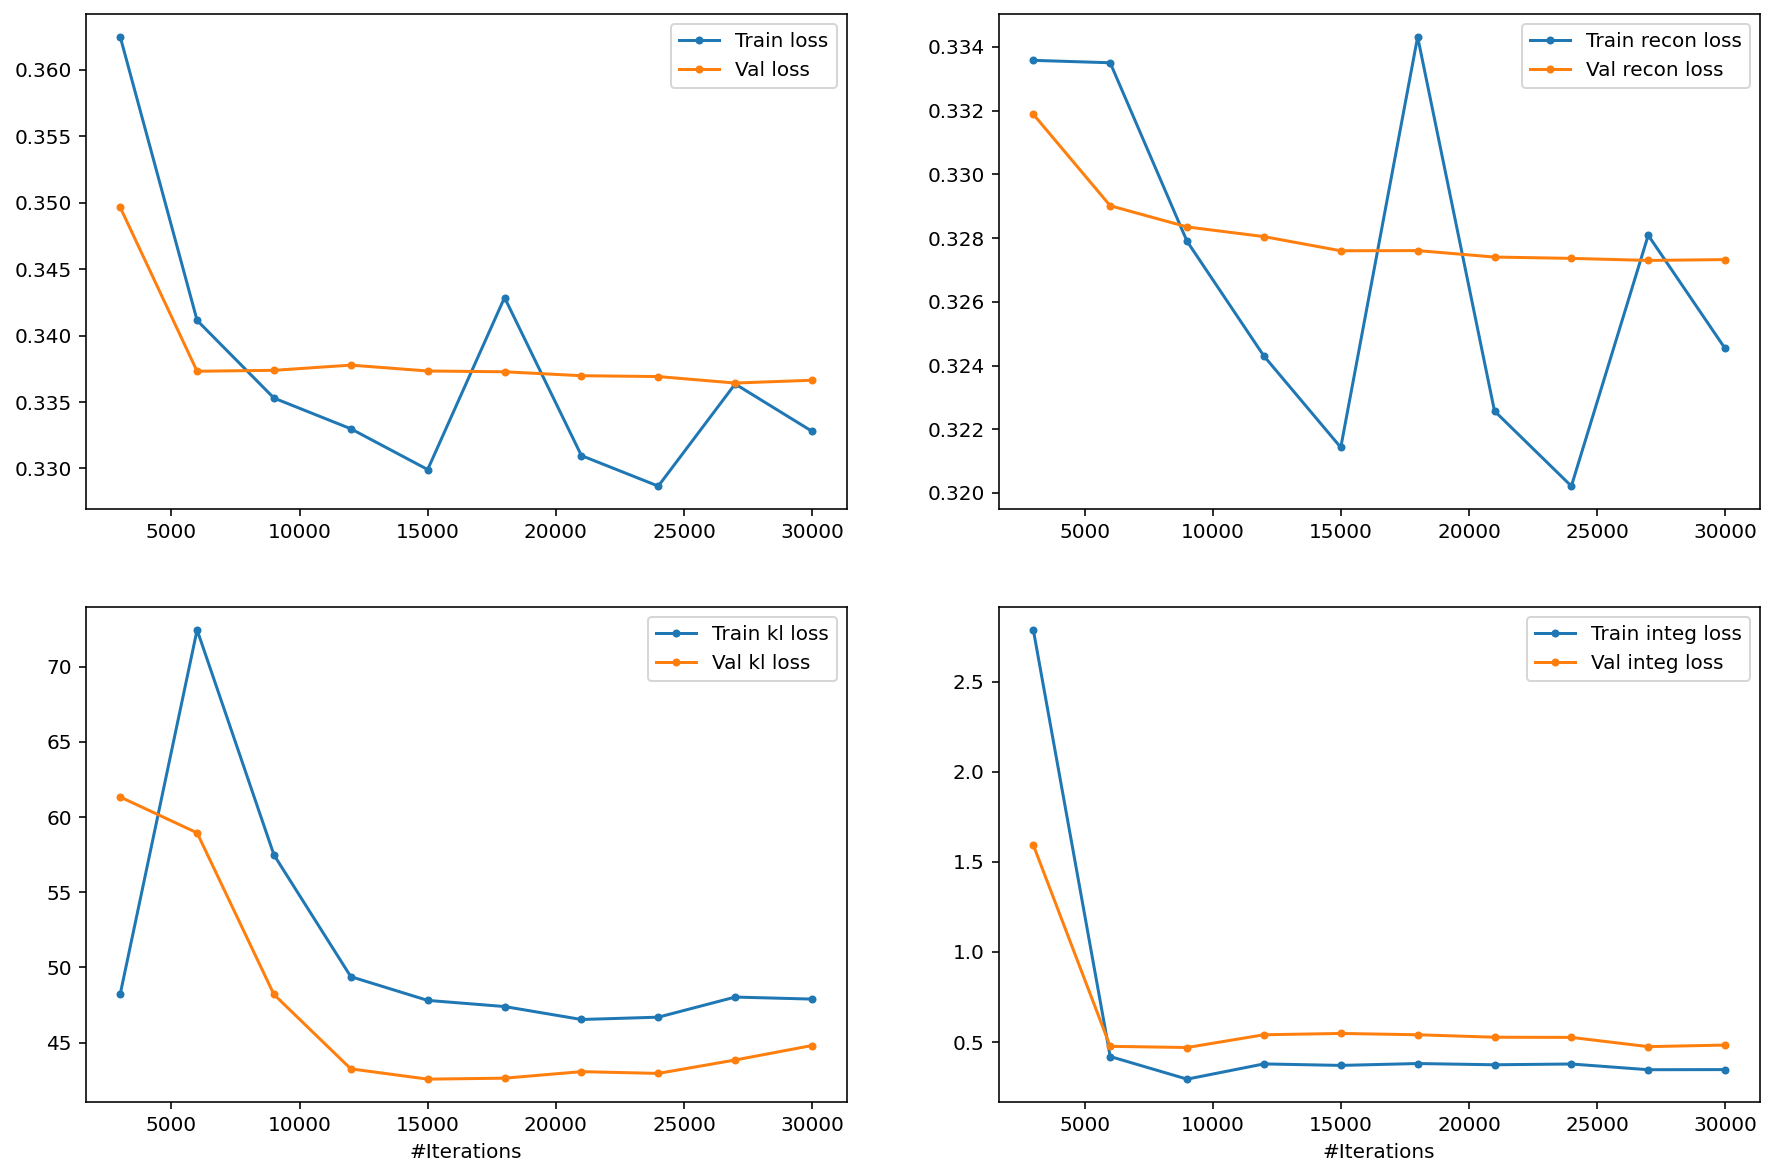

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [10]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 9586 × 20
    obs: 'modality', 'cell_type', 'batch'

In [11]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


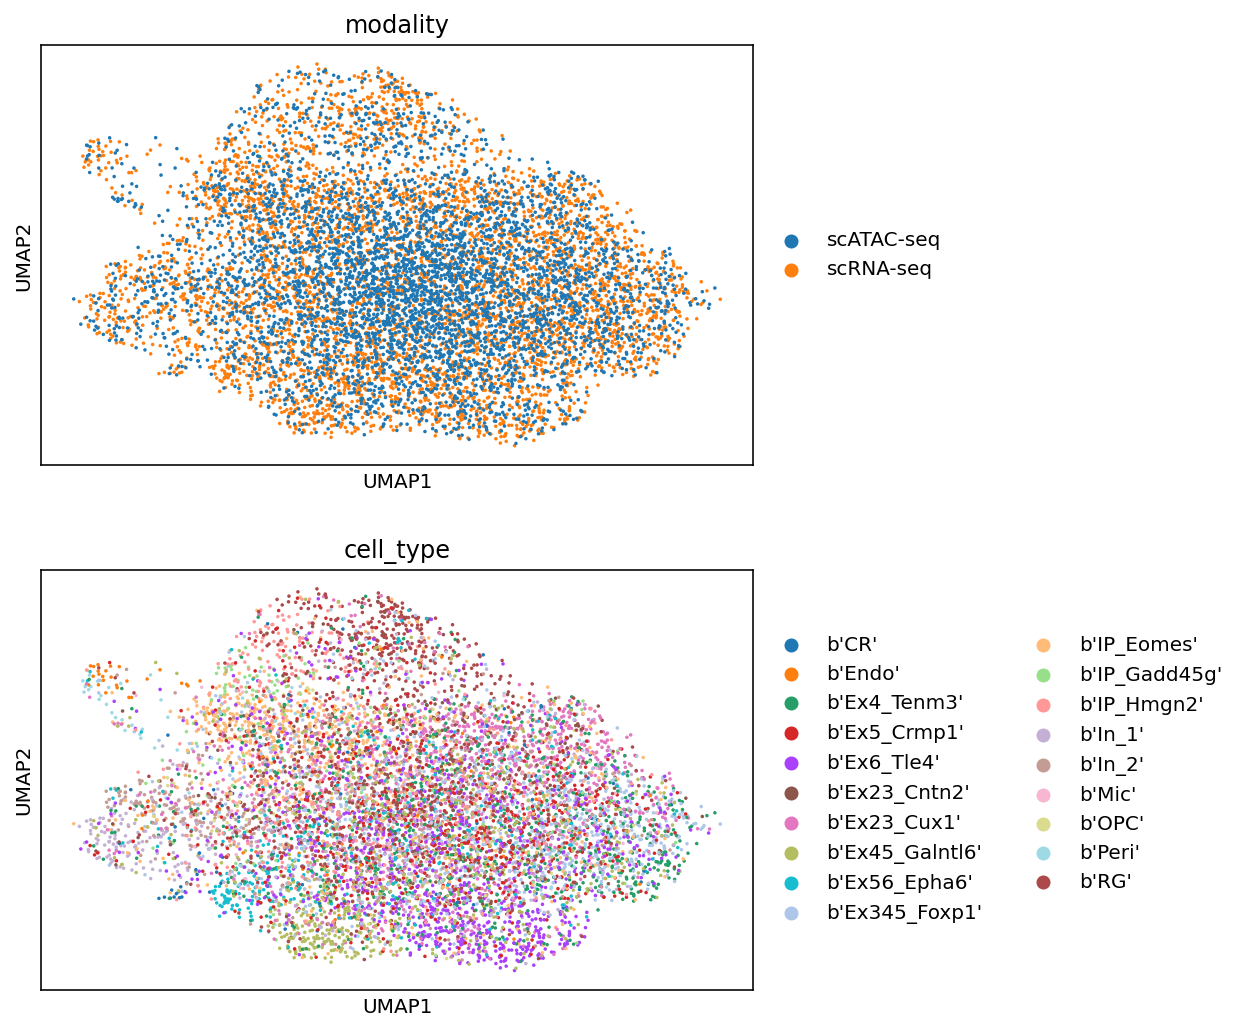

In [12]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

### Metrics

In [13]:
sc.pp.pca(z)
metrics = multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type'
)
metrics

Clustering...
ASW label/batch...


/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be remov

PCR batch...
Graph connectivity...
ASW label...
NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.897927
PCR_batch,0.000000
graph_conn,0.519994
ASW_label,0.482437
NMI_cluster/label,0.114065
ARI_cluster/label,0.071934
isolated_label_silhouette,0.506501


# MOFA 2

In [15]:
from mofapy2.run.entry_point import entry_point

In [16]:
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [17]:
ent.set_data_options(
    scale_groups = False, 
    scale_views = False
)

In [18]:
ent.set_data_matrix([[scrna.X.A], [scatac.X.A]], views_names=['scRNA', 'scATAC'])

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='scRNA' group='group0' with N=4916 samples and D=4000 features...
Successfully loaded view='scATAC' group='group0' with N=4916 samples and D=40019 features...





In [19]:
ent.set_model_options(
    factors = 20, 
    spikeslab_weights = True, 
    ard_factors = True,
    ard_weights = True
)

Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (scRNA): gaussian
- View 1 (scATAC): gaussian




In [20]:
ent.set_train_options(
    iter = 1000, 
    convergence_mode = "fast", 
    startELBO = 1, 
    freqELBO = 1, 
    dropR2 = 0.001, 
    gpu_mode = False, 
    verbose = False, 
    seed = 1
)

In [21]:
ent.build()

In [22]:
ent.run()



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -2679302667.54 

Iteration 1: time=305.68, ELBO=-59279711.72, deltaELBO=2620022955.814 (97.78749477%), Factors=19
Iteration 2: time=200.20, ELBO=-58981892.47, deltaELBO=297819.254 (0.01111555%), Factors=18
Iteration 3: time=207.42, ELBO=-58822768.72, deltaELBO=159123.746 (0.00593900%), Factors=17
Iteration 4: time=142.70, ELBO=-58732179.59, deltaELBO=90589.131 (0.00338107%), Factors=16
Iteration 5: time=201.20, ELBO=-58658667.77, deltaELBO=73511.822 (0.00274369%), Factors=15
Iteration 6: time=128.09, ELBO=-58596418.56, deltaELBO=62249.207 (0.00232334%), Factors=14
Iteration 7: time=154.03, ELBO=-58539939.90, deltaELBO=56478.663 (0.00210796%), Factors=13
Iteration 8: time=129.97, ELBO=-58528920.83, deltaELBO=11019.066 (0.00041127%), Factors=13
Iteration 9: time=126.92, ELBO=-58515251.93, deltaELBO=13668.905 (0.00051017%), Factors=13
Iteration 10: t

In [23]:
outfile = 'chen2019-mofa2.hdf5'
ent.save(outfile)

Saving model in chen2019-mofa2.hdf5...


In [24]:
f = h5py.File(outfile)

In [25]:
z = np.concatenate([v[:,:] for k, v in f['expectations']['Z'].items()], axis=1).T

In [26]:
z.shape

(4916, 10)

In [20]:
# zs = np.concatenate([v[:] for k, v in f["samples"].items()], axis=0).astype(str)
# z = pd.DataFrame(z, index=zs).loc[adata.obs_names.values].to_numpy()

In [21]:
# adata.obsm['X_mofa'] = z
# w = np.concatenate([v[:,:] for k, v in f['expectations']['W'].items()], axis=1).T
# adata.varm['LFs'] = w

In [22]:
# np.concatenate([v[:,:] for k, v in f['expectations']['W'].items()], axis=1).T.shape

In [23]:
# f.keys()

<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'intercepts', 'model_options', 'samples', 'training_opts', 'training_stats', 'variance_explained', 'views']>

In [24]:
# [v for k, v in f['expectations']['W'].items()]

[<HDF5 dataset "scATAC": shape (8, 40019), type "<f8">,
 <HDF5 dataset "scRNA": shape (8, 4000), type "<f8">]

In [27]:
z = sc.AnnData(z)
z.obs['cell_type'] = scrna.obs['cell_type'].tolist()

In [28]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'cell_type' as categorical


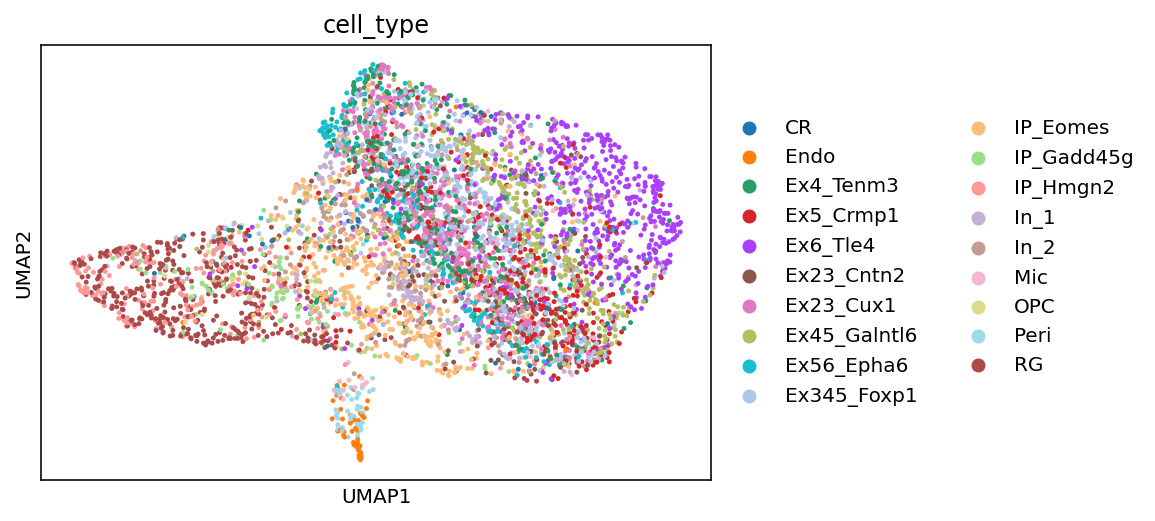

In [29]:
sc.pl.umap(z, color=['cell_type'], ncols=1)

In [30]:
sc.pp.pca(z)
multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    asw_batch=False,
    pcr_batch=False,
    graph_connectivity_batch=False,
    asw_label=True,
    nmi_=True,
    ari_=True,
    isolated_label_asw=False,
    method='MOFA'
)

Clustering...
ASW label...
NMI cluster/label...
ARI cluster/label...


,score
ASW_label,0.464630
NMI_cluster/label,0.330903
ARI_cluster/label,0.209598


# Seurat v4

In [12]:
%%R
library(Seurat)

In [6]:
Convert("data/kotliarov-2020/test.h5ad", dest = "h5seurat", overwrite = TRUE)
rna <- LoadH5Seurat("data/kotliarov-2020/test.h5seurat")



cite = RenameAssays(cite, RNA = 'ADT')

bm = merge(rna, cite)

DefaultAssay(bm) <- 'RNA'
bm = FindVariableFeatures(bm, nfeatures = 3999)
bm = ScaleData(bm)
bm = RunPCA(bm)

DefaultAssay(bm) <- 'ADT'
VariableFeatures(bm) <- rownames(bm[["ADT"]])
bm <- NormalizeData(cibmte, normalization.method = 'CLR', margin = 2)
bm = ScaleData(bm)
bm = RunPCA(bm, reduction.name = 'apca')

bm <- FindMultiModalNeighbors(
       bm, reduction.list = list("pca", "apca"), 
       dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
   )

[1] "salam"
